# PA6: Clustering

## Overview
This notebook gives you hands-on experience with k-means clustering, and shows you two interesting points:
1. You can estimate an appropriate number of clusters by looking at the loss as you increase the number of clusters
2. You can compress images with clustering, pretty effectively!

The outline of this notebook is as follows:
* **Helper functions** (we provide most of these)
  * Generate simulated data based on Gaussian clusters
  * Plot clustered data using principal components
* **k-means clustering** (you provide these)
  * Initialize clusters
  * Record associations (i.e. calculate which cluster centroid is closest to each data point)
  * Update centroids
  * Implement k-means clustering by looping between "associating points" and "updating the centroids"
  * Try k-means clustering on some simulated data, observing how loss changes as the number of clusters changes
* **Compressing an image** (we partially provide these)
  * Split an image into patches
  * Perform k-means clustering on the patches
  * Visualize the patches
  * Reconstruct the original image
  
You can run this notebook either on your local machine, or on Google Colaboratory. Before submitting, please run the whole notebook end-to-end, to make sure the end-results (such as the compressed image) look right!

# Helper Functions

In [1]:
import matplotlib.pyplot as plt
from numpy import random as R
import numpy as np

# Normalizes each row of M to have norm 1
def norm_rows(M):
    return M / np.sqrt(np.sum(M * M, axis=1, keepdims=True))

# X is the data points: each row is a data point
# C is a 1-d array of integers, each entry in C corresponds to a row in X, so len(C) = X.shape[0]
# bb is the bounding box
# `colors` indicates the colors: the default colors the 
#     first cluster `b` or blue, next cluster `g` or green, etc.
# Plot d-dimensional sample with cluster indicators thru projections on principal components
def plot_sample(X, C, bb=[], ms=10, colors='bgrcmk'):
    if X.shape[1] > 2: 
        _, v = np.linalg.eig(X.T @ X)
        v = np.array(v, dtype=np.float32)
        # v[:,0:2] is the two most significant eigenvectors
        # X @ v[:,0:2] projects X onto these two eigenvectors
        Xplot = X @ v[:,0:2]
    else:
        Xplot = X
    from itertools import cycle
    k = int(C.max()) + 1
    fig = plt.figure('Sample (Projected)', figsize=(8,8))
    if bb != []:
        plt.xlim(bb[0]), plt.ylim(bb[1])
    cycol = cycle(colors)
    for i in range(k):
        ind = C == i
        col = next(cycol)
        plt.scatter(Xplot[ind,0], Xplot[ind,1], s=ms, c=col)

### Mixture of Gaussians Simulation and Visualization


The below equation is for your curiosity: it shows the distribution equation of points in a $k$-mixture of Gaussians.

Let $\mathbf{x}\in\mathbb{R}^d$ and $k\in \mathbb{N}_+$. The density function of a $k$-mixture of Gaussians is:

$$
\mathsf{
D[x] = \sum_{i=1}^k
  \frac{\pi_i}{\sqrt{(2\pi)^k\big|S_i\big|}}
  \exp\!\Big(\!-\frac12 \big(\mathbf{x}-\mathbf{c}_{i}\big)^\top S_i \, \big(\mathbf{x}-\mathbf{c}_{i}\big)\Big)
}
$$

### Generate Parameters for  Mixture of k Gaussians with Centers located on d-dimensional sphere of radius sep

In [1]:
# Generate Parameters for a Mixture of k Gaussian Models
# Centers are located on a d-dimensional sphere of radius sep
# This function will be used to generate some sample data, which will be distributed
#   according to a mixture of multi-dimensional Gaussian distributions
# A single Gaussian distribution produces data points clustered around a particular mean point,
#   so a mixture of Gaussians produces data clustered at a few different mean points
def generate_mixture_params(k, d, iso=True, sep=1):
    Pi = np.exp(R.randn(k) / np.sqrt(k))
    Pi = Pi / sum(Pi)
    Mu = sep * norm_rows(R.randn(k, d))
    Si  = [] 
    for i in range(k):
        A = R.randn(d, 3 * d) 
        A = A @ A.T
        A = np.linalg.det(A) ** (-1/k) * A # To prevent spikiness
        if iso:
            A = np.diag(np.diag(A))
        Si.append(A)
    Si = np.array(Si)
    return (Pi, Mu, Si)

### Sampling by allocating exact proportions w.r.t  $\pi$ & then sampling from corresponding mod of mixture


In [4]:
# `sample_from_mog` samples `n` points from a mixture of Gaussians: `mog` holds the Gaussian parameters
# This function produces simulated data, on which you'll perform clustering
# The output `C` is a 1-D numpy array, C[i] indicates which Gaussian produced X[i]
# The output `X` is a 2-D numpy array: each row X[i] is a data point

# Bonus ACT (optional): Explain, in a few sentences, what is going on in this function and how
#   we are sampling these points. It may help to look at documentation of the relevant functions.
def sample_from_mog(mog, n):
    Pi, Mu, Si = mog
    k, d = Mu.shape
    s = R.multinomial(n, Pi)
    X = np.zeros((n, d))
    C = np.zeros(n)
    po = 0
    for i in range(k):
        pn = po + s[i]
        X[po:pn,:] = R.multivariate_normal(Mu[i], Si[i], s[i])
        C[po:pn] = i
        po = pn
    return C, X

# Clustering Using k-Means

Here, you'll implement k-means clustering. We'll call your input data $X$, and your cluster centroids $W$. Each row of $X$ is a data point, each row of $W$ is a cluster centroid, and your goal is to choose centroids so every data point is close to a centroid.

We will use the squared loss here, so the loss is the average squared distance between each point and the nearest centroid. More precisely, if our centroids are $\mathbf{w}_1, \ldots, \mathbf{w}_k$ and our points are $\mathbf{x}_1, \ldots, \mathbf{x}_n$, then our loss is:
$$\sum_{i=1}^n \min_j ||\mathbf{x}_i - \mathbf{w}_j||^2$$

In [5]:
import torch
import torch.nn.functional as F

# this uses a GPU if available, and otherwise uses your CPU
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ACT1
# M is a 2-D matrix
# calculate the squared norms of the columns of M,
#   and output an array containing these squared norms
def cnorm2(M):
    return ### ACT 1

In [6]:
# ACT2
# `init` outputs `k` initial clusters, based on data `X`
# As before, `X` is a 2-D array, and each row of `X` is a data point
# You should output a 2-D array `C`, where each row of `C` is a cluster centroid
# To pick your initial clusters, pick `k` random data points from `X`
# Output `W`, a 2-D array of cluster centroids, where each row is a centroid
def init(X, k):
    n = X.shape[0]
    ### ACT 2

### Step-by-step for `l2associate`

For `l2associate`, your goal is to find the clusters associated with each point, and the average squared distance from each point to its corresponding centroid.

We need the squared distance between each point and each centroid. Looping through each example in X is too slow, so we'll walk you through a trick you can use to speed it up.

Let $x_i$ and $w_j$ be the $i$-th and $j$-th rows of $X$ and $W$. We'd like to find the squared distance between each point and each cluster centroid: this helps compute the square loss, and to find the closest centroid we just choose the centroid with the smallest square distance. Now, the trick! It turns out that
$$||x_i - w_j||^2 = ||x_i||^2 + ||w_j||^2 - 2(x_i\cdot w_j)$$

To find the squared distance between each point, first we compute the squared norm of each row of $X$ (corresponds to $||x_i||^2$ in the above equation) and the squared row norms of $W$ ($||w_j||^2$). You can do this by transposing $X$ and $W$ and using the `cnorm2` function.

To find $x\cdot w$, we multiply $X W^T$, which results in an array where the in $(i, j)$-th entry equals $x_i\cdot w_j$, the inner product of the $i$-th row of $X$ with the $j$-th row of $W$.

What we want is a 2-D array where the $(i, j)$-th entry is the distance between $x_i$ and $w_j$. We can make a matrix where the $(i,j)$-th entry is $||x_i||^2 + ||w_j||^2$ by summing a column of $X$'s row-norms with a row of $W$'s row-norms (PyTorch will automatically perform the broadcasting of if one is a column vector and the other a row vector). Then, from this matrix, we subtract 2 times $X\cdot W^T$.

Alternatively, you can use torch's `repeat()` to fill a 2-D array with the row-norms of $X$ and another 2-D array with the row-norms of $W$, and then sum these two together and subtract 2 times $X\cdot W^T$. https://pytorch.org/docs/stable/tensors.html#torch.Tensor.repeat

In [7]:
# ACT3
# `X` is a 2-D PyTorch array of data, each row is a data point
# `W` is a 2-D PyTorch array of cluster centroids, each row is a centroid
# Output min_dists.mean(), the average squared distance to the nearest centroid,
#   and assoc, a 1-D array indicating the centroid closest to each point
def l2associate(X, W):
    # ACT 3a: Find row norms of X and W (X.T gives you X-transpose)
    xn = ### your cnorm2 function can be handy here
    wn = ###
    
    # ACT3b: Make a 2-D array where the $(i, j)$-th entry is the squared distance between $x_i$ and $w_j$
    sq_dists = ###
    
    # ACT3c: Find the minimum and argmin (index of the minimum) in each row of sq_dists
    # this tells which centroid is closest, and its squared distance
    min_dists = ###
    assoc = ###
    
    # .item() extracts a number from a PyTorch Tensor
    # .view(-1) makes clusts 1-dimensional
    return (min_dists.mean()).item(), assoc.view(-1)

### Tips for `l2estimate`

Your goal is to output a 2-D array of cluster centroids, based on `X` and `assoc`. `assoc` indicates which examples correspond to each cluster: your new centroids should be the average of all the points associated with that centroid.

It's fine to use a for-loop here, iterating as `i` goes from `1` to `k`. Normally we avoid for-loops for speed, but since `k` is small, iterating from `1` to `k` doesn't add much time. You don't need to use a for-loop though, and it's possible to avoid one!

In [8]:
# ACT4
# `k` is the number of clusters
# `assoc` is an array indicating the centroid closest to each point
# output a 2-D array of cluster centroids, where each row is a centroid
# if there are no points associated with a centroid, you should make that centroid equal to a 0-vector
def l2estimate(X, k, assoc):
    W = torch.zeros(k, X.shape[1])
    ### ACT 4
    return W

In [9]:
# ACT5
# Perform k-means clustering on X, using k clusters, running for max_epochs cycles,
#   and stopping early if loss decreases by a proportion less than eps
# Output the final centroids W, and loss, a vector containing the loss at each time step
def kMeans(X, k, max_epochs=20, eps=1e-3):
    loss = []
    W = # initialize W, your centroids
    # for max_epochs iterations, loop through the following:
    #   - find dist and assoc
    #   - append dist to loss
    #   - update W based on assoc
    #   - check for early stopping: if appropriate, check whether (loss[-2] - loss[-1]) / loss[-1] < eps
    #     - you don't need to check for early stopping for the first two epochs
    return W, loss

## Small scale test

Now that we've implemented k-means clustering, let's run an experiment on simulated data.

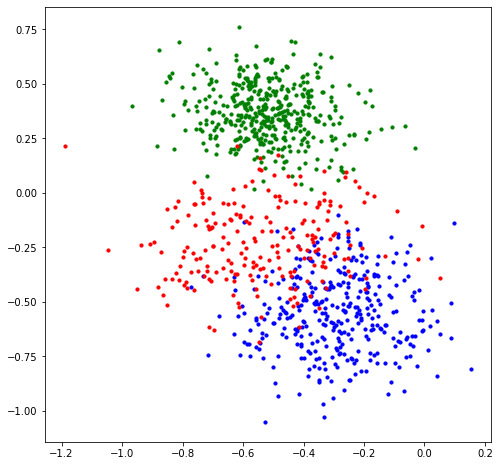

In [28]:
# fix random seeds: you can change these seeds freely to get different datasets!
torch.manual_seed(4)
np.random.seed(4)

# In this experiment, d is relatively small: so the generated data is closer together.
# When d is larger, the generated data is easier to separate
# You can play with this yourself! But change back to the original parameters when submitting
n, d, k = 1000, 7, 3
mog = generate_mixture_params(k, d, iso=False, sep=np.sqrt(k/d))
C, Xt = sample_from_mog(mog, n)  # Xt and C are numpy arrays
plot_sample(Xt, C)
X = torch.from_numpy(Xt).float().to(dev)  # make X a PyTorch array
# To plot these 7-dimensional points in 2-dimensions, we project onto the two principal components
# (in linear algebra, the eigenvectors for the two highest eigenvalues)
# Conceptually, this is just projecting onto a 2-d plane that gives us a clear picture

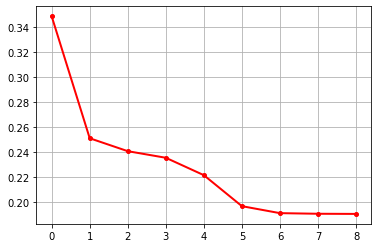

In [11]:
# ACT6
W, loss =  # Call kMeans clustering on the data X, using k clusters

# we plot the loss
plt.plot(loss, lw=2, ms=4, c='r', marker='o')
plt.grid()
_ = plt.axis('tight')

## Experiment with highly-separated clusters

In this experiment, `d` is higher, and the points are very well-separated. In an easily-clustered example like this one, we will show how looking at the loss can give us a hint on how many clusters is appropriate!

In [12]:
n, d, k = 10000, 20, 5

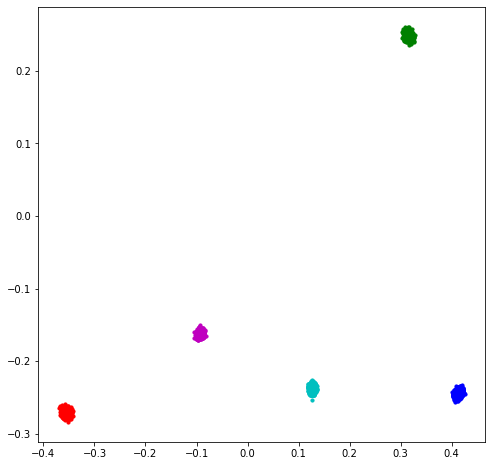

In [13]:
mog = generate_mixture_params(k, d, iso=False, sep=np.sqrt(k/d))
C, Xt = sample_from_mog(mog, n)
plot_sample(Xt, C)
X = torch.from_numpy(Xt).float().to(dev)

In [29]:
W1, loss = kMeans(X, 1)
print('[{:-2}/{:-2}] {:7.0}'.format(1, 1, loss[-1]))
bl = loss[-1] * np.ones(3*k)
nz = np.zeros(3*k, dtype=int)
for test_k in np.arange(2, 2*k+1):
    for e in range(100):
        W, loss = kMeans(X, test_k)
        if loss[-1] < bl[test_k]:
            bl[test_k] = loss[-1]
            nz[test_k] = (cnorm2(W.T) != 0).sum().item()
    print('[{:-2}/{:-2}] {:-7.4}'.format(nz[test_k], test_k, bl[test_k].round(4)))

# Here, we test out many different values of k (test_k), and print out
#   the best loss achieved with that number of centroids.
#   nz is the number of non-zero centroids, and test_k is the number of centroids

[ 1/ 1]     0.4
[ 2/ 2]  0.2485
[ 3/ 3]  0.1901
[ 4/ 4]  0.1765
[ 5/ 5]  0.1641
[ 6/ 6]  0.1552


**ACT7**: Explain how you could use the loss in the above example to infer how many clusters are appropriate for the data (a one-sentence answer is enough).

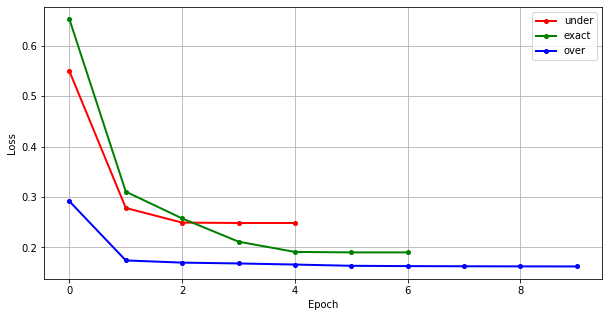

In [34]:
Wu, loss_u = kMeans(X, round(k/2))  # under (too few clusters)
We, loss_e = kMeans(X, k)  # exact (the right number of clusters)
Wo, loss_o = kMeans(X, 2 * k)  # over (too many clusters)

plt.figure('Loss (per Epoch)', figsize=(10,5))
plt.plot(loss_u, lw=2, ms=4, c='r', marker='o')
plt.plot(loss_e, lw=2, ms=4, c='g', marker='o')
plt.plot(loss_o, lw=2, ms=4, c='b', marker='o')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(('under', 'exact', 'over')), plt.grid()
_ = plt.axis('tight')
# Nothing to do here: we've just plotted this for your interest

# Compressing an Image with Clustering

In lecture, we compressed an image using clustering, by clustering each separate pixel. However, what about clustering patches of an image instead of individual pixels? In this section, we explore how this can work.

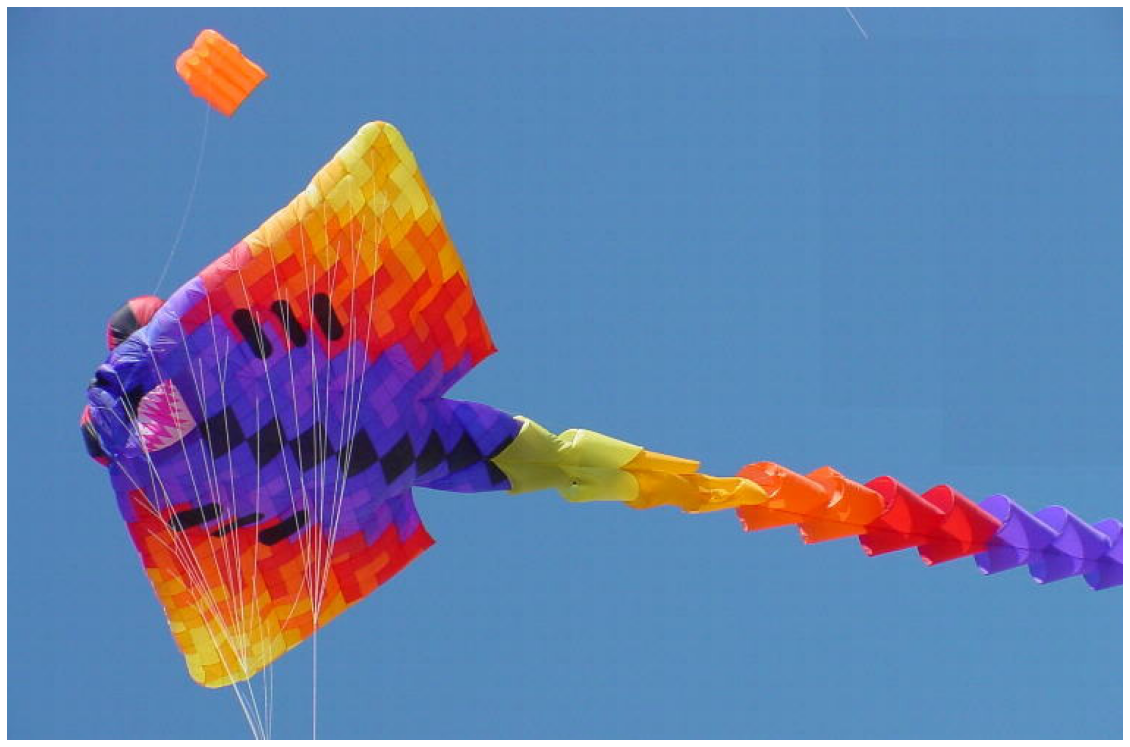

In [16]:
import urllib
from matplotlib.image import imread

# make sure the image is in the same folder as your notebook, or adjust the path to point to the right image
image = plt.imread('kite3.jpeg') # you can cluster a different image by changing the file path here
plt.figure(num=None, figsize=(20, 30))
plt.imshow(image)
_ = plt.axis('off')

image = np.float32(image)
nx, ny = image.shape[0:2]

In [17]:
# extracted patches are of size ps x ps
ps = 5
pad = 4 * [ps // 2]  # pad the image by ps//2 on all 4 sides

# Separate channels and pad each color channel
Xr = F.pad(torch.tensor(image[:,:,0]), pad)
Xg = F.pad(torch.tensor(image[:,:,1]), pad)
Xb = F.pad(torch.tensor(image[:,:,2]), pad)

# Create patches, flatten, and pack into a single matrix
Pr = Xr.unfold(0, ps, 1).unfold(1, ps, 1).reshape(-1, ps * ps)
Pg = Xg.unfold(0, ps, 1).unfold(1, ps, 1).reshape(-1, ps * ps)
Pb = Xb.unfold(0, ps, 1).unfold(1, ps, 1).reshape(-1, ps * ps)
V = torch.cat([Pr, Pg, Pb], dim=1).to(dev)

In [18]:
num_clusters = 256
b_loss = 1e10
# ACT8: verify that column dimensions of V correspond to patch size squared, times number of color channels
#   a.k.a. assert that the number of columns in V is equal to 3 * ps * ps.

assert ### fill in here

for e in range(3):
    W, pl = # ACT9: perform kmeans clustering on V with num_clusters
    if pl[-1] < b_loss:
        b_loss, b_W, b_pl = pl[-1], W, pl
    
    nz = # ACT10: calculate the number of non-empty clusters in W
    # HINT: we did this earlier in this notebook, and you may look at our code as a reference
    
    # avg_patch_loss stands for the loss when averaged over all pixels in a patch
    avg_patch_loss = pl[-1] / (3 * ps * ps)
    print('[{:-2}/{:-2}] {:-7.4f}'.format(nz, num_clusters, avg_patch_loss))

# b stands for best, such as best_W or best_patch_loss
W, pl = b_W, b_pl

[242/256] 103.4311
[249/256] 105.0575
[247/256] 100.2963


### Visualize the cluster centroids

Each centroid is a vector of length $3 * ps^2$. In order to visualize the centroids, we need to reshape each vector to a tensor of shape $ps \times ps \times 3$ and then round each entry to an integer in $\{0,\ldots,255\}$.

**ACT11**: In the visualized "patch centroids" below, why are there so many blue patches? HINT: It has to do with how we initialized the centroids from real image patches. A short answer is sufficient here, perhaps one-two sentences.

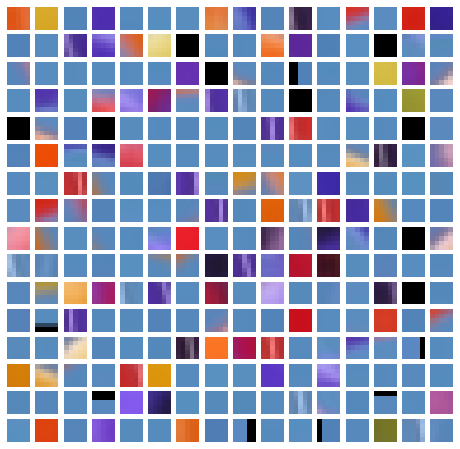

In [19]:
patches = (W.reshape(num_clusters, 3, ps, ps)).numpy()
patches = np.moveaxis(patches, 1, 3).round().astype(int)
xyp = int(np.sqrt(num_clusters))
plt.figure(figsize=(8, 8))
for idx in range(num_clusters):
    plt.subplot(xyp, xyp, idx + 1)
    plt.imshow(patches[idx,:,:,:])
    plt.axis('off')

### Examine learning before proceeding with reconstruction

Just a simple plot of the loss over time as we perform clustering.

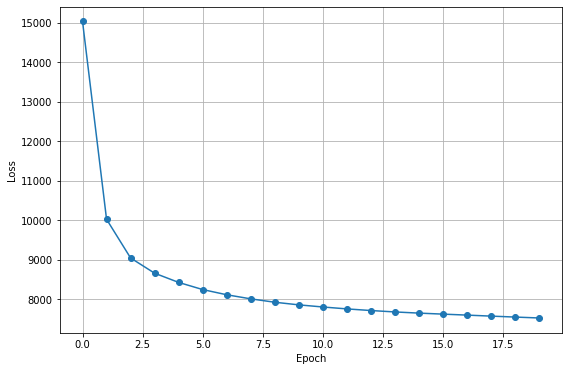

In [20]:
plt.figure(figsize=(9, 6)), plt.plot(pl, marker='o')
_ = plt.axis('tight'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.grid()

### Replace each patch with its closest centroid

In [21]:
# ACT12: if V is the image vector, and W is the centroids,
#   HINT: what function do you call to find the indices of the closest centroid to each point?
_, inds = ### ACT 12
Vcmpct = C[inds,:].reshape(-1, 3, ps, ps)

### Reconstruct compressed image

In [22]:
# Here, we're just reconstructing V back into the original image shape
# It's a bit of a pain, but take a mental note of (and perhaps Google) the functions we use here,
#   as they can be useful for tensor manipulation in your future work
nc0 = Vcmpct[:,0,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc0 = F.fold(nc0, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

nc1 = Vcmpct[:,1,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc1 = F.fold(nc1, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

nc2 = Vcmpct[:,2,:,:].reshape(-1, ps*ps).T.reshape(1, ps*ps, -1)
nc2 = F.fold(nc2, output_size=(nx, ny), padding=(ps // 2), kernel_size=ps).squeeze().numpy()

new_image = (np.stack((nc0, nc1, nc2), axis=2) / (ps * ps)).round().astype(int)

### Display reconstructed image

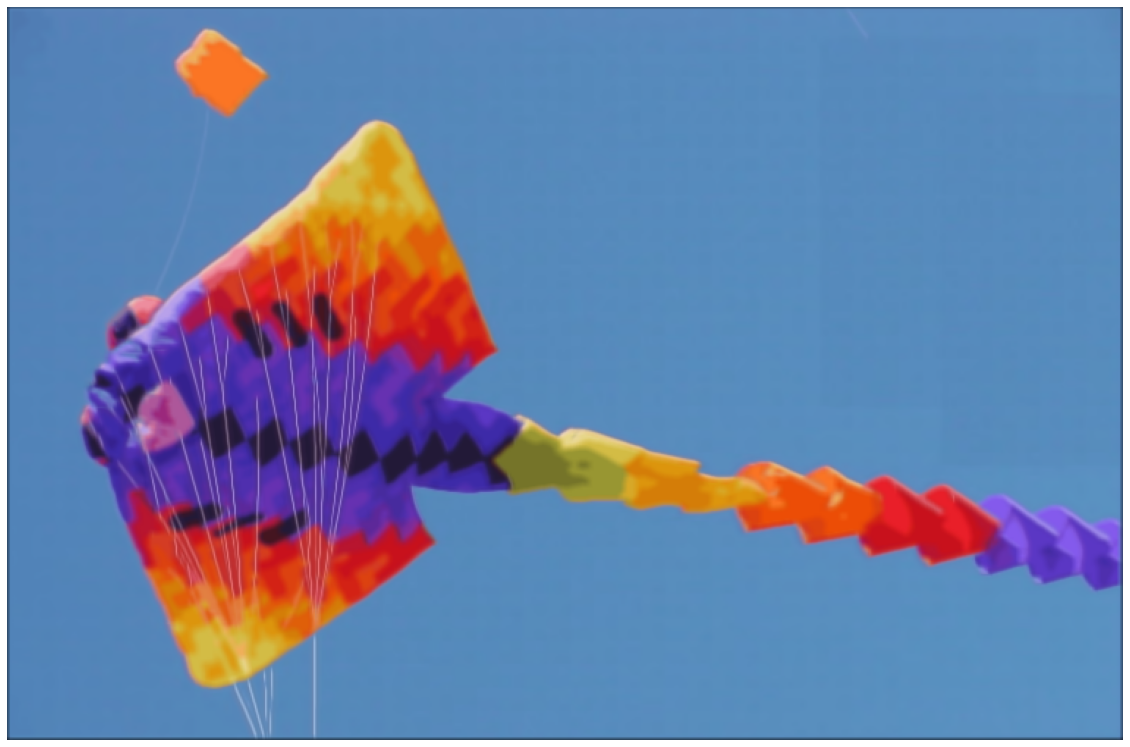

In [23]:
plt.figure(num=None, figsize=(20, 30))
plt.imshow(new_image)
_ = plt.axis('off')

In [ ]:
# ACT13: Repeat the above compression of the kite image, except use num_clusters=9 instead of 256.
# You are welcome to copy previous cells liberally!